In [1]:
import tensorflow as tf
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from plotly import tools
import chart_studio.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# init_notebook_mode(connected=True)
from imblearn.over_sampling import SMOTE
from collections import Counter
import time
import os

# % matplotlib inline

# df = pd.read_feather("""D:\Foundations_of_DataScience\Projects\Final_projects\lending_club_dataset_2007_2020\lending_club_clean.feather""")


dfs = []
for i in range(73):
    file_path = os.path.join(f'chunk_{i}.csv')
    df = pd.read_csv(file_path)
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True)
df=data.copy()

In [2]:
df.columns

Index(['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title',
       ...
       'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date',
       'hardship_length', 'hardship_dpd', 'hardship_loan_status',
       'orig_projected_additional_accrued_interest',
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'debt_settlement_flag'],
      dtype='object', length=141)

In [3]:
df = df.rename(columns={"loan_amnt": "loan_amount", "funded_amnt": "funded_amount", "funded_amnt_inv": "investor_funds",
                       "int_rate": "interest_rate", "annual_inc": "annual_income"})

df.drop(['id', 'emp_title', 'url', 'zip_code', 'title'], axis=1, inplace=True)

Text(0.5, 1.0, 'Total committed by Investors')

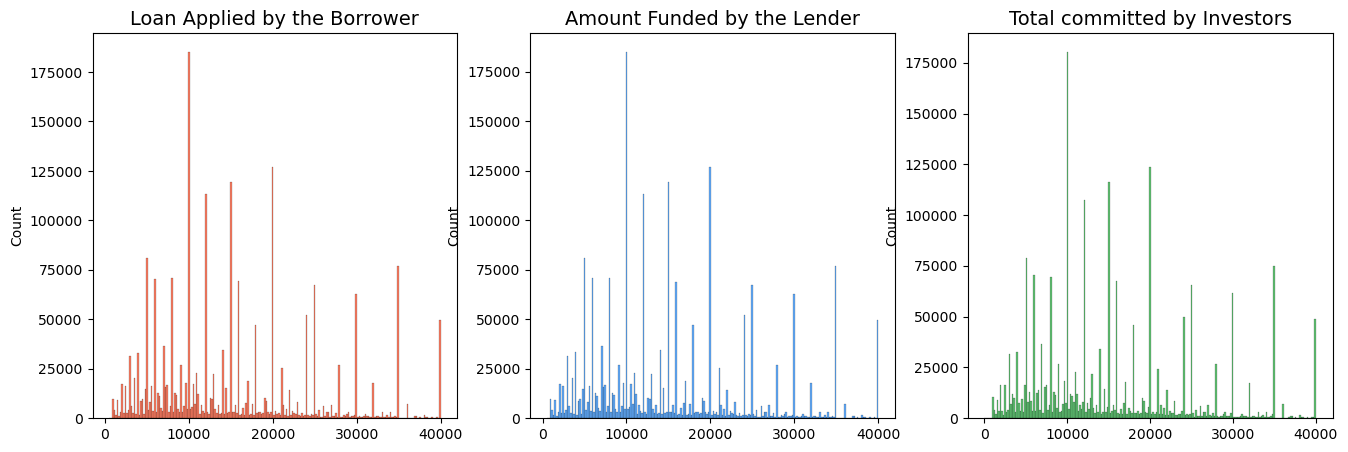

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(16,5))

loan_amount = df["loan_amount"].values
funded_amount = df["funded_amount"].values
investor_funds = df["investor_funds"].values
sns.histplot(loan_amount, ax=ax[0], color="#F7522F")
ax[0].set_title("Loan Applied by the Borrower", fontsize=14)
sns.histplot(funded_amount, ax=ax[1], color="#2F8FF7")
ax[1].set_title("Amount Funded by the Lender", fontsize=14)
sns.histplot(investor_funds, ax=ax[2], color="#2EAD46")
ax[2].set_title("Total committed by Investors", fontsize=14)

Text(0, 0.5, 'Average loan amount issued')

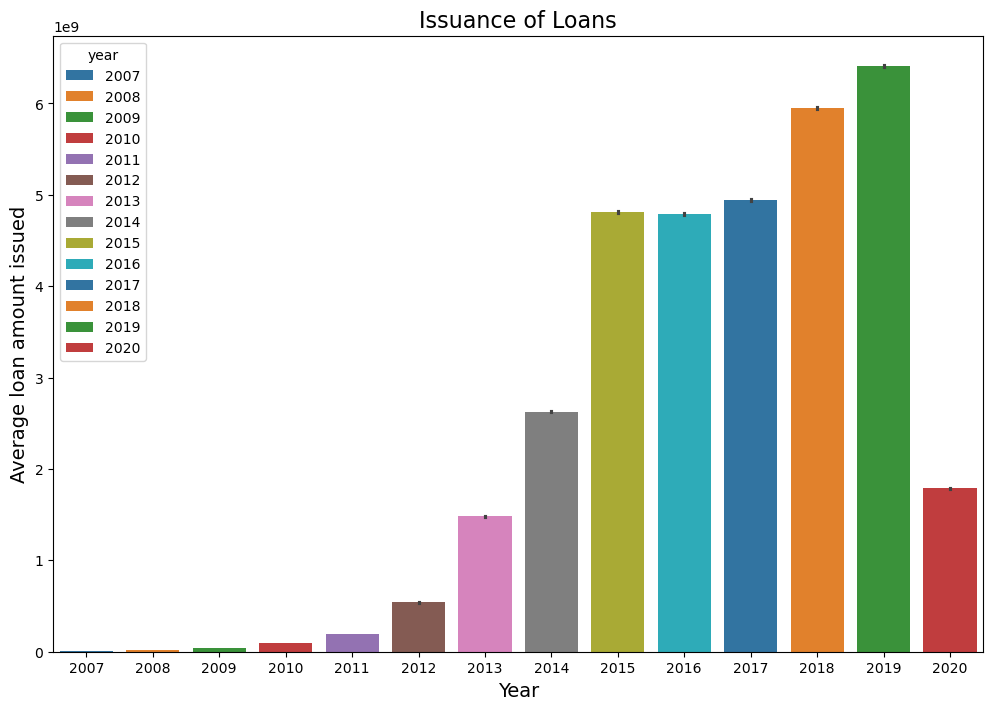

In [5]:
df['issue_d'].head()
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%Y-%m-%d')
df['issue_d'] = pd.to_datetime(df['issue_d'], format='mixed', errors='coerce')
# df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y')
df['year'] = df['issue_d'].dt.year
plt.figure(figsize=(12,8))
sns.barplot(x='year', y='loan_amount', data=df, hue='year', palette='tab10',estimator=sum,legend=True)
plt.title('Issuance of Loans', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average loan amount issued', fontsize=14)

- Most of the loans issued were in the range of 10,000 to 20,000 USD.
- The year of 2019 was the year were most loans were issued.
- Loans were issued in an incremental manner.
- The loans applied by potential borrowers, the amount issued to the borrowers and the amount funded by investors are similarly distributed, meaning that it is most likely that qualified borrowers are going to get the loan they had applied for.

In [6]:
df["loan_status"].value_counts()

loan_status
Fully Paid                                             1123337
Current                                                 773262
Charged Off                                             271911
Late (31-120 days)                                       12115
In Grace Period                                           7521
Late (16-30 days)                                         2039
Issued                                                    1547
Does not meet the credit policy. Status:Fully Paid        1491
Does not meet the credit policy. Status:Charged Off        571
Default                                                    325
Name: count, dtype: int64

In [7]:
bad_loan = ["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off", "In Grace Period", 
            "Late (16-30 days)", "Late (31-120 days)"]


df['loan_condition'] = np.nan

def loan_condition(status):
    if status in bad_loan:
        return 'Bad Loan'
    else:
        return 'Good Loan'
df['loan_condition'] = df['loan_status'].apply(loan_condition)

[Text(0, 0.5, '(%)')]

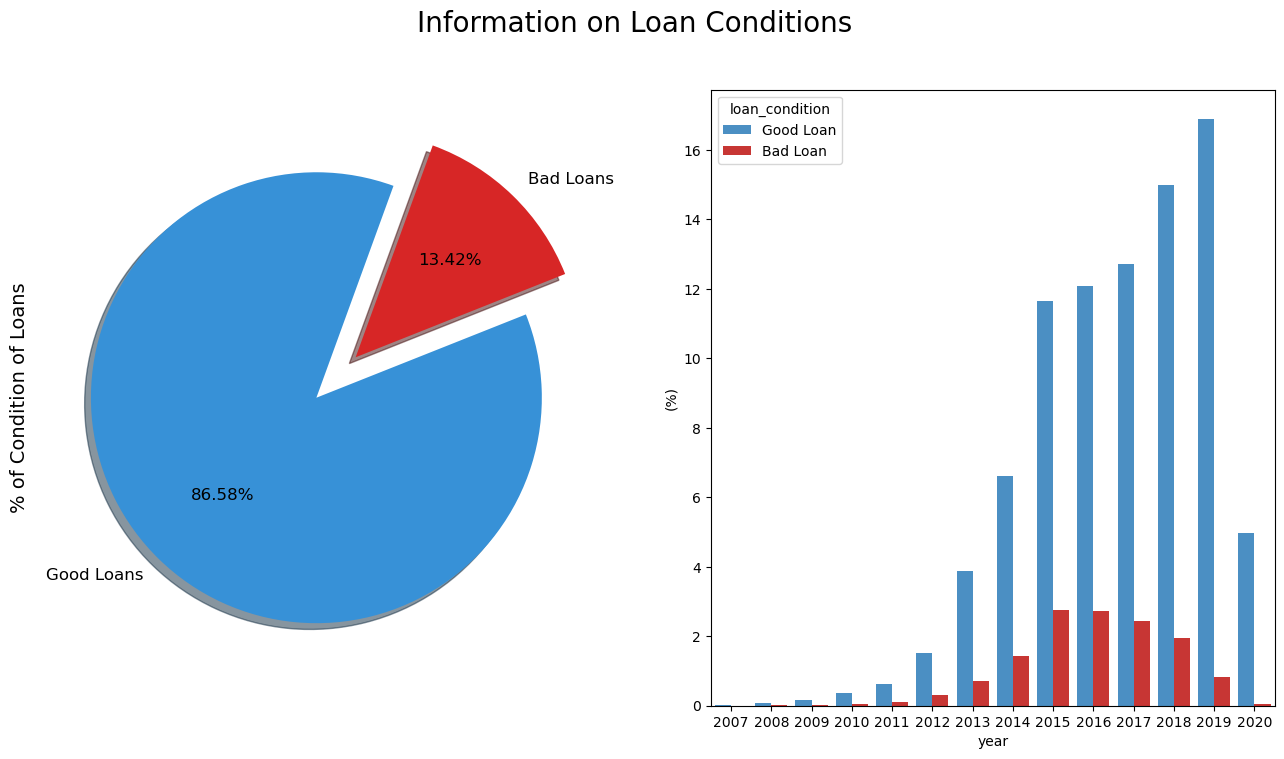

In [8]:
f, ax = plt.subplots(1,2, figsize=(16,8))

colors = ["#3791D7", "#D72626"]
labels ="Good Loans", "Bad Loans"

plt.suptitle('Information on Loan Conditions', fontsize=20)

df["loan_condition"].value_counts().plot.pie(explode=[0,0.25], autopct='%1.2f%%', ax=ax[0], shadow=True, colors=colors, 
                                             labels=labels, fontsize=12, startangle=70)
ax[0].set_ylabel('% of Condition of Loans', fontsize=14)
palette = ["#3791D7", "#E01E1B"]

sns.barplot(x="year", y="loan_amount", hue="loan_condition", data=df, palette=palette, estimator=lambda x: len(x) / len(df) * 100)
ax[1].set(ylabel="(%)")

- Currently, bad loans consist 13.42% of total loans but remember that we still have current loans which have the risk of becoming bad loans. (So this percentage is subjected to possible changes.)
- The NorthEast region seems to be the most attractive in term of funding loans to borrowers.
- The SouthWest and West regions have experienced a slight increase in the "median income" in the past years.
- Average interest rates have declined since 2012 but this might explain the increase in the volume of loans.
- Employment Length tends to be greater in the regions of the SouthWest and West
- Clients located in the regions of NorthEast and MidWest have not experienced a drastic increase in debt-to-income(dti) as compared to the other regions.

In [9]:
df['addr_state'].unique()

west = ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID']
south_west = ['AZ', 'TX', 'NM', 'OK']
south_east = ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN' ]
mid_west = ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND']
north_east = ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']

df['region'] = np.nan

def finding_regions(state):
    if state in west:
        return 'West'
    elif state in south_west:
        return 'SouthWest'
    elif state in south_east:
        return 'SouthEast'
    elif state in mid_west:
        return 'MidWest'
    elif state in north_east:
        return 'NorthEast'
df['region'] = df['addr_state'].apply(finding_regions)

In [10]:
# df['complete_date'] = pd.to_datetime(df['issue_d'])
df['complete_date'] = pd.to_datetime(df['issue_d'], format='%b-%Y')
group_dates = df.groupby(['complete_date', 'region'], as_index=False).sum(numeric_only=True)
group_dates['issue_d'] = group_dates['complete_date'].dt.to_period('M')
group_dates = group_dates.groupby(['issue_d', 'region'], as_index=False).sum(numeric_only=True)
group_dates['loan_amount'] = group_dates['loan_amount'] / 1000
df_dates = pd.DataFrame(data=group_dates[['issue_d', 'region', 'loan_amount']])

Text(0.5, 1.0, 'Loans issued by Region')

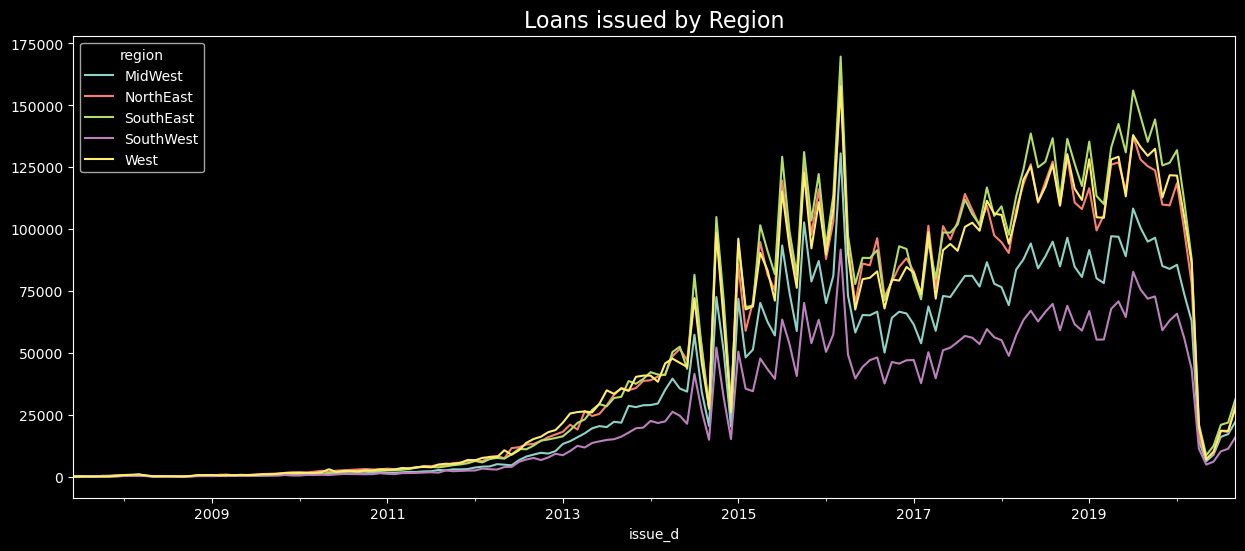

In [11]:
plt.style.use('dark_background')
cmap = plt.cm.Set3

by_issued_amount = df_dates.groupby(['issue_d', 'region']).loan_amount.sum()
by_issued_amount.unstack().plot(stacked=False, colormap=cmap, grid=False, legend=True, figsize=(15,6))

plt.title('Loans issued by Region', fontsize=16)

In [14]:
employment_length = ['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
                    '4 years', '5 years', '6 years', '2 years', '7 years', 'n/a']

# Create a new column and convert emp_length to integers.

lst = [df]
df['emp_length_int'] = np.nan

for col in lst:
    col.loc[col['emp_length'] == '10+ years', "emp_length_int"] = 10
    col.loc[col['emp_length'] == '9 years', "emp_length_int"] = 9
    col.loc[col['emp_length'] == '8 years', "emp_length_int"] = 8
    col.loc[col['emp_length'] == '7 years', "emp_length_int"] = 7
    col.loc[col['emp_length'] == '6 years', "emp_length_int"] = 6
    col.loc[col['emp_length'] == '5 years', "emp_length_int"] = 5
    col.loc[col['emp_length'] == '4 years', "emp_length_int"] = 4
    col.loc[col['emp_length'] == '3 years', "emp_length_int"] = 3
    col.loc[col['emp_length'] == '2 years', "emp_length_int"] = 2
    col.loc[col['emp_length'] == '1 year', "emp_length_int"] = 1
    col.loc[col['emp_length'] == '< 1 year', "emp_length_int"] = 0.5
    col.loc[col['emp_length'] == 'n/a', "emp_length_int"] = 0

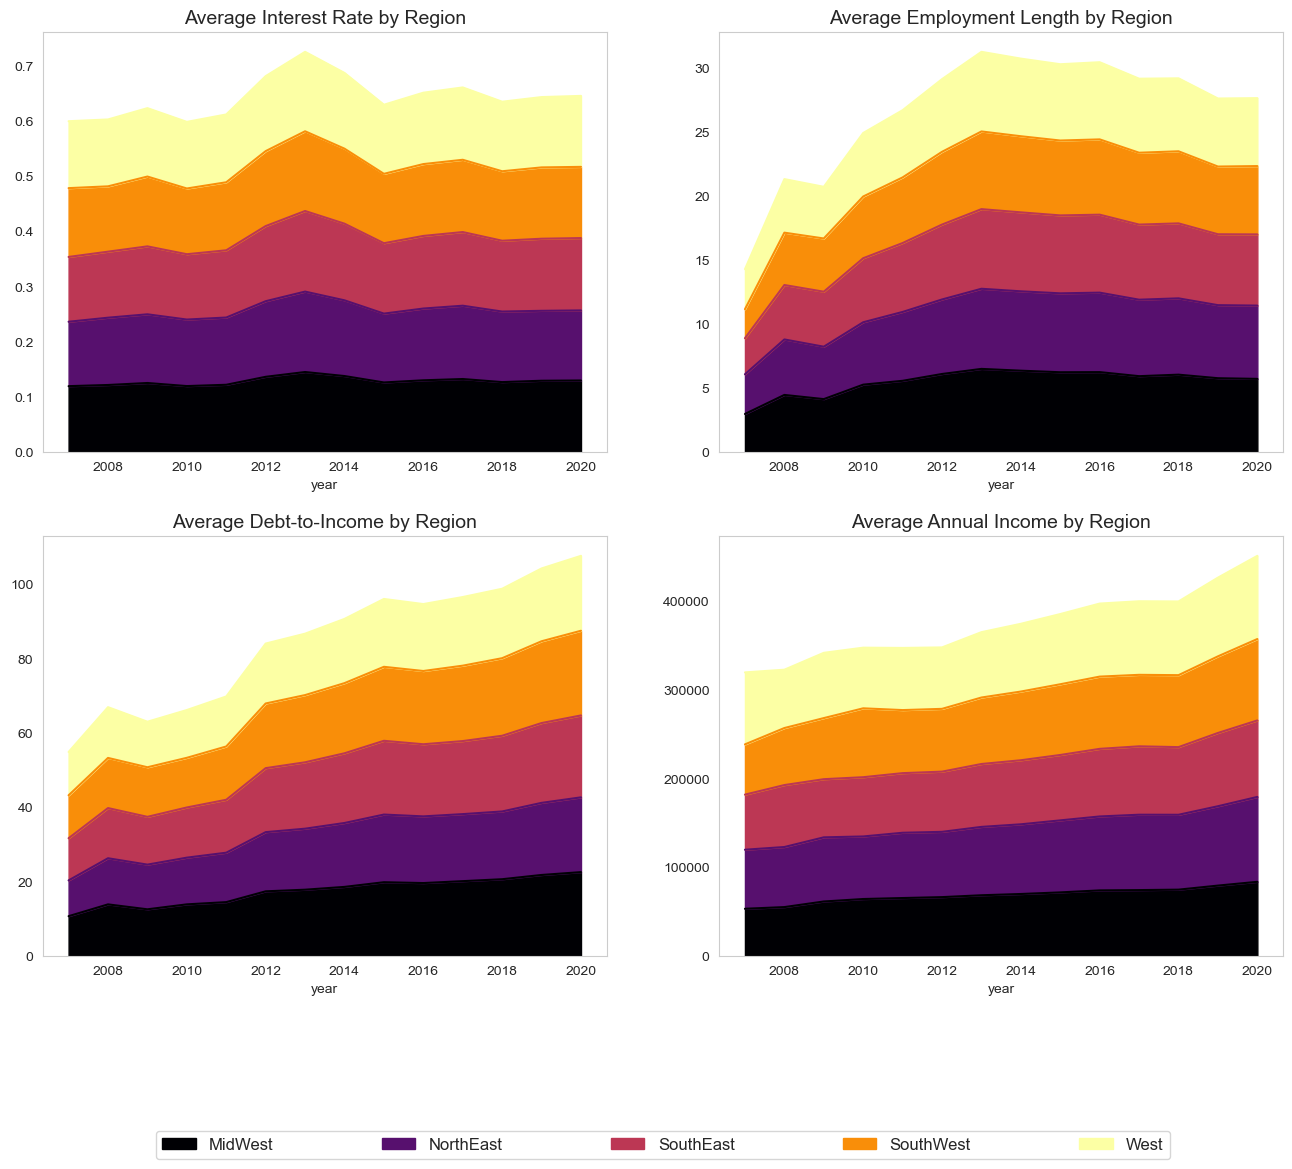

In [15]:
sns.set_style('whitegrid')

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
cmap = plt.cm.inferno

by_interest_rate = df.groupby(['year', 'region']).interest_rate.mean()
by_interest_rate.unstack().plot(kind='area', stacked=True, colormap=cmap, grid=False, legend=False, ax=ax1, figsize=(16,12))
ax1.set_title('Average Interest Rate by Region', fontsize=14)


by_employment_length = df.groupby(['year', 'region']).emp_length_int.mean()
by_employment_length.unstack().plot(kind='area', stacked=True, colormap=cmap, grid=False, legend=False, ax=ax2, figsize=(16,12))
ax2.set_title('Average Employment Length by Region', fontsize=14)
# plt.xlabel('Year of Issuance', fontsize=14)

by_dti = df.groupby(['year', 'region']).dti.mean()
by_dti.unstack().plot(kind='area', stacked=True, colormap=cmap, grid=False, legend=False, ax=ax3, figsize=(16,12))
ax3.set_title('Average Debt-to-Income by Region', fontsize=14)

by_income = df.groupby(['year', 'region']).annual_income.mean()
by_income.unstack().plot(kind='area', stacked=True, colormap=cmap, grid=False, ax=ax4, figsize=(16,12))
ax4.set_title('Average Annual Income by Region', fontsize=14)
ax4.legend(bbox_to_anchor=(-1.0, -0.5, 1.8, 0.1), loc=10,prop={'size':12},
           ncol=5, mode="expand", borderaxespad=0.)

- SouthEast , West and NorthEast regions had the highest amount lof loans issued.
- West and SouthWest had a rapid increase in debt-to-income starting in 2012.
- West and SouthWest had a rapid decrease in interest rates (This might explain the increase in debt to income).

In [16]:
badloans_df = df.loc[df["loan_condition"] == "Bad Loan"]
loan_status_cross = pd.crosstab(badloans_df['region'], badloans_df['loan_status']).apply(lambda x: x/x.sum() * 100)
number_of_loanstatus = pd.crosstab(badloans_df['region'], badloans_df['loan_status'])
loan_status_cross['Charged Off'] = loan_status_cross['Charged Off'].apply(lambda x: round(x, 2))
loan_status_cross['Default'] = loan_status_cross['Default'].apply(lambda x: round(x, 2))
loan_status_cross['Does not meet the credit policy. Status:Charged Off'] = loan_status_cross['Does not meet the credit policy. Status:Charged Off'].apply(lambda x: round(x, 2))
loan_status_cross['In Grace Period'] = loan_status_cross['In Grace Period'].apply(lambda x: round(x, 2))
loan_status_cross['Late (16-30 days)'] = loan_status_cross['Late (16-30 days)'].apply(lambda x: round(x, 2))
loan_status_cross['Late (31-120 days)'] = loan_status_cross['Late (31-120 days)'].apply(lambda x: round(x, 2))


number_of_loanstatus['Total'] = number_of_loanstatus.sum(axis=1) 
number_of_loanstatus

loan_status,Charged Off,Default,Does not meet the credit policy. Status:Charged Off,In Grace Period,Late (16-30 days),Late (31-120 days),Total
region,,,,,,,
MidWest,46703,53,103,1168,322,1917,50266
NorthEast,63417,67,150,2007,526,2965,69132
SouthEast,68744,87,137,1955,526,2962,74411
SouthWest,33216,39,54,855,215,1513,35892
West,59831,79,127,1536,450,2758,64781


In [17]:
charged_off = loan_status_cross['Charged Off'].values.tolist()
default = loan_status_cross['Default'].values.tolist()
not_meet_credit = loan_status_cross['Does not meet the credit policy. Status:Charged Off'].values.tolist()
grace_period = loan_status_cross['In Grace Period'].values.tolist()
short_pay = loan_status_cross['Late (16-30 days)'] .values.tolist()
long_pay = loan_status_cross['Late (31-120 days)'].values.tolist()
charged = go.Bar(
    x=['MidWest', 'NorthEast', 'SouthEast', 'SouthWest', 'West'],
    y= charged_off,
    name='Charged Off',
    marker=dict(
        color='rgb(192, 148, 246)'
    ),
    text = '%'
)

defaults = go.Bar(
    x=['MidWest', 'NorthEast', 'SouthEast', 'SouthWest', 'West'],
    y=default,
    name='Defaults',
    marker=dict(
        color='rgb(176, 26, 26)'
    ),
    text = '%'
)

credit_policy = go.Bar(
    x=['MidWest', 'NorthEast', 'SouthEast', 'SouthWest', 'West'],
    y= not_meet_credit,
    name='Does not meet Credit Policy',
    marker = dict(
        color='rgb(229, 121, 36)'
    ),
    text = '%'
)

grace = go.Bar(
    x=['MidWest', 'NorthEast', 'SouthEast', 'SouthWest', 'West'],
    y= grace_period,
    name='Grace Period',
    marker = dict(
        color='rgb(147, 147, 147)'
    ),
    text = '%'
)

short_pays = go.Bar(
    x=['MidWest', 'NorthEast', 'SouthEast', 'SouthWest', 'West'],
    y= short_pay,
    name='Late Payment (16-30 days)', 
    marker = dict(
        color='rgb(246, 157, 135)'
    ),
    text = '%'
)

long_pays = go.Bar(
    x=['MidWest', 'NorthEast', 'SouthEast', 'SouthWest', 'West'],
    y= long_pay,
    name='Late Payment (31-120 days)',
    marker = dict(
        color = 'rgb(238, 76, 73)'
        ),
    text = '%'
)

data = [charged, defaults, credit_policy, grace, short_pays, long_pays]
layout = go.Layout(
    barmode='stack',
    title = '% of Bad Loan Status by Region',
    xaxis=dict(title='US Regions')
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='stacked-bar')

In [18]:
print(df['interest_rate'].mean(),df['annual_income'].mean())

0.1304257506391992 79940.95477014237


- The regions of the West and SouthEast had a higher percentage in most of the b "bad" loan statuses.
- The NorthEast region had a higher percentage in Grace Period and Does not meet Credit Policy loan status. However, both of these are not considered as bad as default for instance.
- Based on this small and brief summary we can conclude that the West and SouthEast regions have the most undesirable loan status, but just by a slightly higher percentage compared to the NorthEast region.
- Again, this does not tell us what causes a loan to be a bad loan , but it gives us some idea about the level of risk within the regions across the United States.

In [19]:
by_loan_amount = df.groupby(['region','addr_state'], as_index=False).loan_amount.sum()
by_interest_rate = df.groupby(['region', 'addr_state'], as_index=False).interest_rate.mean()
by_income = df.groupby(['region', 'addr_state'], as_index=False).annual_income.mean()
states = by_loan_amount['addr_state'].values.tolist()
average_loan_amounts = by_loan_amount['loan_amount'].values.tolist()
average_interest_rates = by_interest_rate['interest_rate'].values.tolist()
average_annual_income = by_income['annual_income'].values.tolist()
from collections import OrderedDict
metrics_data = OrderedDict([('state_codes', states),
                            ('issued_loans', average_loan_amounts),
                            ('interest_rate', average_interest_rates),
                            ('annual_income', average_annual_income)])
metrics_df = pd.DataFrame.from_dict(metrics_data)
metrics_df = metrics_df.round(decimals=2)
metrics_df.head()

,state_codes,issued_loans,interest_rate,annual_income
0,IA,65175,0.13,42898.70
1,IL,1386459575,0.13,81859.72
2,IN,545376100,0.13,71734.49
3,KS,278894125,0.13,73410.86
4,MI,824198675,0.13,73355.45


In [20]:
import chart_studio.plotly as py
import plotly.graph_objs as go


for col in metrics_df.columns:
    metrics_df[col] = metrics_df[col].astype(str)
    
scl = [[0.0, 'rgb(210, 241, 198)'],[0.2, 'rgb(188, 236, 169)'],[0.4, 'rgb(171, 235, 145)'],\
            [0.6, 'rgb(140, 227, 105)'],[0.8, 'rgb(105, 201, 67)'],[1.0, 'rgb(59, 159, 19)']]

metrics_df['text'] = metrics_df['state_codes'] + '<br>' +\
'Average loan interest rate: ' + metrics_df['interest_rate'] + '<br>'+\
'Average annual income: ' + metrics_df['annual_income'] 


data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = metrics_df['state_codes'],
        z = metrics_df['issued_loans'], 
        locationmode = 'USA-states',
        text = metrics_df['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "$s USD")
        ) ]


layout = dict(
    title = 'Issued Loans',
    geo = dict(
        scope = 'usa',
        projection=dict(type='albers usa'),
        showlakes = True,
        lakecolor = 'rgb(255, 255, 255)')
)

fig = dict(data=data, layout=layout)
iplot(fig, filename='d3-cloropleth-map')

- California, Texas, New York and Florida are the states in which the highest amount of loans were issued.
- Interesting enough, all four states have a approximate interest rate of 13% which is at the same level of the average interest rate for all states (13.24%)
- California, Texas and New York are all above the average annual income (with the exclusion of Florida), this might give possible indication why most loans are issued in these states.

In [21]:
df['income_category'] = np.nan
lst = [df]

for col in lst:
    col.loc[col['annual_income'] <= 100000, 'income_category'] = 'Low'
    col.loc[(col['annual_income'] > 100000) & (col['annual_income'] <= 200000), 'income_category'] = 'Medium'
    col.loc[col['annual_income'] > 200000, 'income_category'] = 'High'

C:\Users\jasth\AppData\Local\Temp\ipykernel_31464\19384439.py:5: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



In [22]:
lst = [df]
df['loan_condition_int'] = np.nan

for col in lst:
    col.loc[df['loan_condition'] == 'Good Loan', 'loan_condition_int'] = 0 # Negative (Bad Loan)
    col.loc[df['loan_condition'] == 'Bad Loan', 'loan_condition_int'] = 1 # Positive (Good Loan) 
df['loan_condition_int'] = df['loan_condition_int'].astype(int)

<Axes: xlabel='income_category', ylabel='interest_rate'>

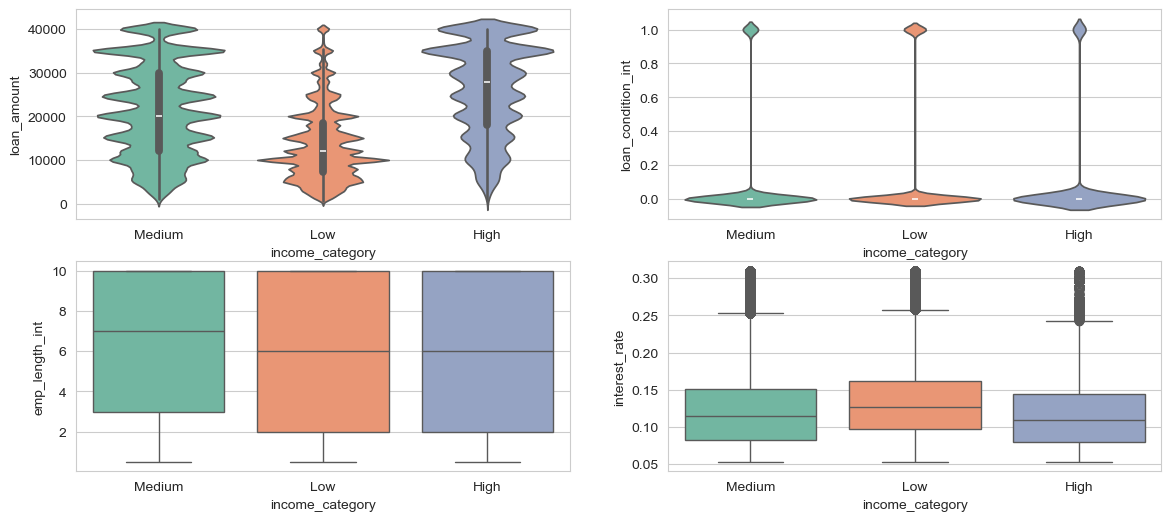

In [23]:
fig, ((ax1, ax2), (ax3, ax4))= plt.subplots(nrows=2, ncols=2, figsize=(14,6))

sns.violinplot(x="income_category", y="loan_amount", data=df, hue="income_category",palette="Set2", ax=ax1 )
sns.violinplot(x="income_category", y="loan_condition_int", data=df, hue="income_category",palette="Set2", ax=ax2)
sns.boxplot(x="income_category", y="emp_length_int", data=df, hue="income_category",palette="Set2", ax=ax3)
sns.boxplot(x="income_category", y="interest_rate", data=df, hue="income_category",palette="Set2", ax=ax4)

- Borrowers that made part of the high income category took higher loan amounts than people from low and medium income categories. Of course, people with higher annual incomes are more likely to pay loans with a higher amount. (First row to the left of the subplots)
- Loans that were borrowed by the Low income category had a slightly higher change of becoming a bad loan. (First row to the right of the subplots)
- Borrowers with High and Medium annual incomes had a longer employment length than people with lower incomes.(Second row to the left of the subplots)
- Borrowers with a lower income had on average higher interest rates while people with a higher annual income had lower interest rates on their loans. (Second row to the right of the subplots)

In [ ]:
# print(len(state_codes))
# print(len(default_ratio))
# print(len(number_of_badloans))
# print(len(percentage_ofall_badloans))
# print(len(average_dti))
# print(len(average_emp_length))

NameError: name 'default_ratio' is not defined

In [28]:
by_condition = df.groupby('addr_state')['loan_condition'].value_counts()/ df.groupby('addr_state')['loan_condition'].count()
by_emp_length = df.groupby(['region', 'addr_state'], as_index=False).emp_length_int.mean().sort_values(by="addr_state")

loan_condition_bystate = pd.crosstab(df['addr_state'], df['loan_condition'] )

cross_condition = pd.crosstab(df["addr_state"], df["loan_condition"])
percentage_loan_contributor = pd.crosstab(df['addr_state'], df['loan_condition']).apply(lambda x: x/x.sum() * 100)
condition_ratio = cross_condition["Bad Loan"]/cross_condition["Good Loan"]
by_dti = df.groupby(['region', 'addr_state'], as_index=False).dti.mean()
state_codes = sorted(states)
default_ratio = condition_ratio.values.tolist()
average_dti = by_dti['dti'].values.tolist()
average_emp_length = by_emp_length["emp_length_int"].values.tolist()
number_of_badloans = loan_condition_bystate['Bad Loan'].values.tolist()
percentage_ofall_badloans = percentage_loan_contributor['Bad Loan'].values.tolist()
risk_data = OrderedDict([('state_codes', state_codes),
                         ('default_ratio', default_ratio),
                         ('badloans_amount', number_of_badloans),
                         ('percentage_of_badloans', percentage_ofall_badloans),
                         ('average_dti', average_dti),
                         ('average_emp_length', average_emp_length)])
risk_df = pd.DataFrame.from_dict(risk_data)
risk_df = risk_df.round(decimals=3)
risk_df.head()

,state_codes,default_ratio,badloans_amount,percentage_of_badloans,average_dti,average_emp_length
0,AK,0.149,648,0.220,15.726,6.128
1,AL,0.190,4158,1.412,19.168,6.361
2,AR,0.188,2630,0.893,20.888,6.150
3,AZ,0.153,7029,2.387,20.789,5.573
4,CA,0.160,41780,14.188,19.727,5.824


In [30]:
for col in risk_df.columns:
    risk_df[col] = risk_df[col].astype(str)
    
scl = [[0.0, 'rgb(202, 202, 202)'],[0.2, 'rgb(253, 205, 200)'],[0.4, 'rgb(252, 169, 161)'],\
            [0.6, 'rgb(247, 121, 108  )'],[0.8, 'rgb(232, 70, 54)'],[1.0, 'rgb(212, 31, 13)']]

risk_df['text'] = risk_df['state_codes'] + '<br>' +\
'Number of Bad Loans: ' + risk_df['badloans_amount'] + '<br>' + \
'Percentage of all Bad Loans: ' + risk_df['percentage_of_badloans'] + '%' +  '<br>' + \
'Average Debt-to-Income Ratio: ' + risk_df['average_dti'] + '<br>'+\
'Average Length of Employment: ' + risk_df['average_emp_length'] 


data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = risk_df['state_codes'],
        z = risk_df['default_ratio'], 
        locationmode = 'USA-states',
        text = risk_df['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "%")
        ) ]


layout = dict(
    title = 'Analyzing Risks',
    geo = dict(
        scope = 'usa',
        projection=dict(type='albers usa'),
        showlakes = True,
        lakecolor = 'rgb(255, 255, 255)')
)

fig = dict(data=data, layout=layout)
iplot(fig, filename='d3-cloropleth-map')

IOWA has the highest level of default ratio neverthless, the amount of loans issued in that state is too low. (Number of Bad loans is equal to 3)
California and Texas seem to have the lowest risk and the highest possible return for investors. However, I will look more deeply into these states and create other metrics analyze the level of risk for each state.

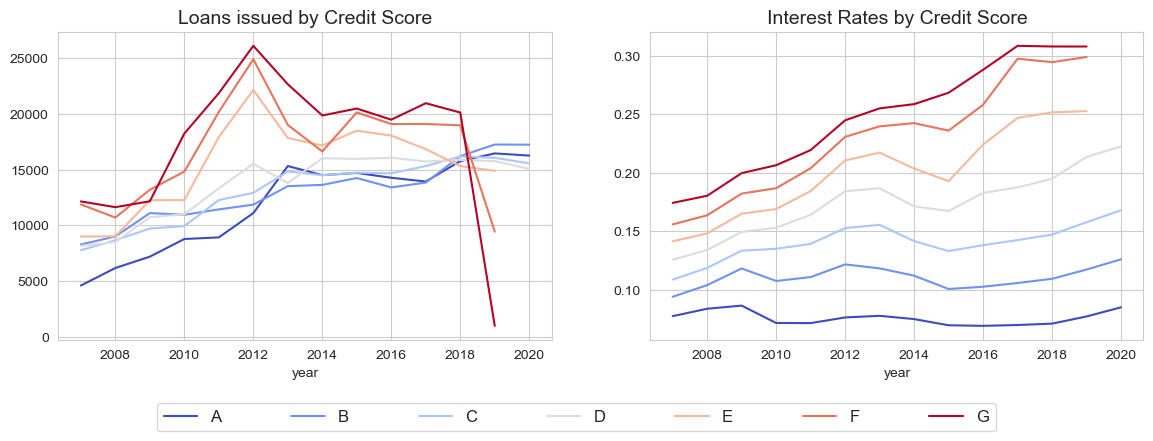

In [31]:
f, ((ax1, ax2)) = plt.subplots(1, 2)
cmap = plt.cm.coolwarm

by_credit_score = df.groupby(['year', 'grade']).loan_amount.mean()
by_credit_score.unstack().plot(legend=False, ax=ax1, figsize=(14, 4), colormap=cmap)
ax1.set_title('Loans issued by Credit Score', fontsize=14)
    
    
by_inc = df.groupby(['year', 'grade']).interest_rate.mean()
by_inc.unstack().plot(ax=ax2, figsize=(14, 4), colormap=cmap)
ax2.set_title('Interest Rates by Credit Score', fontsize=14)

ax2.legend(bbox_to_anchor=(-1.0, -0.3, 1.7, 0.1), loc=5, prop={'size':12},
           ncol=7, mode="expand", borderaxespad=0.)

Text(0, 0.5, 'Interest Rate (%)')

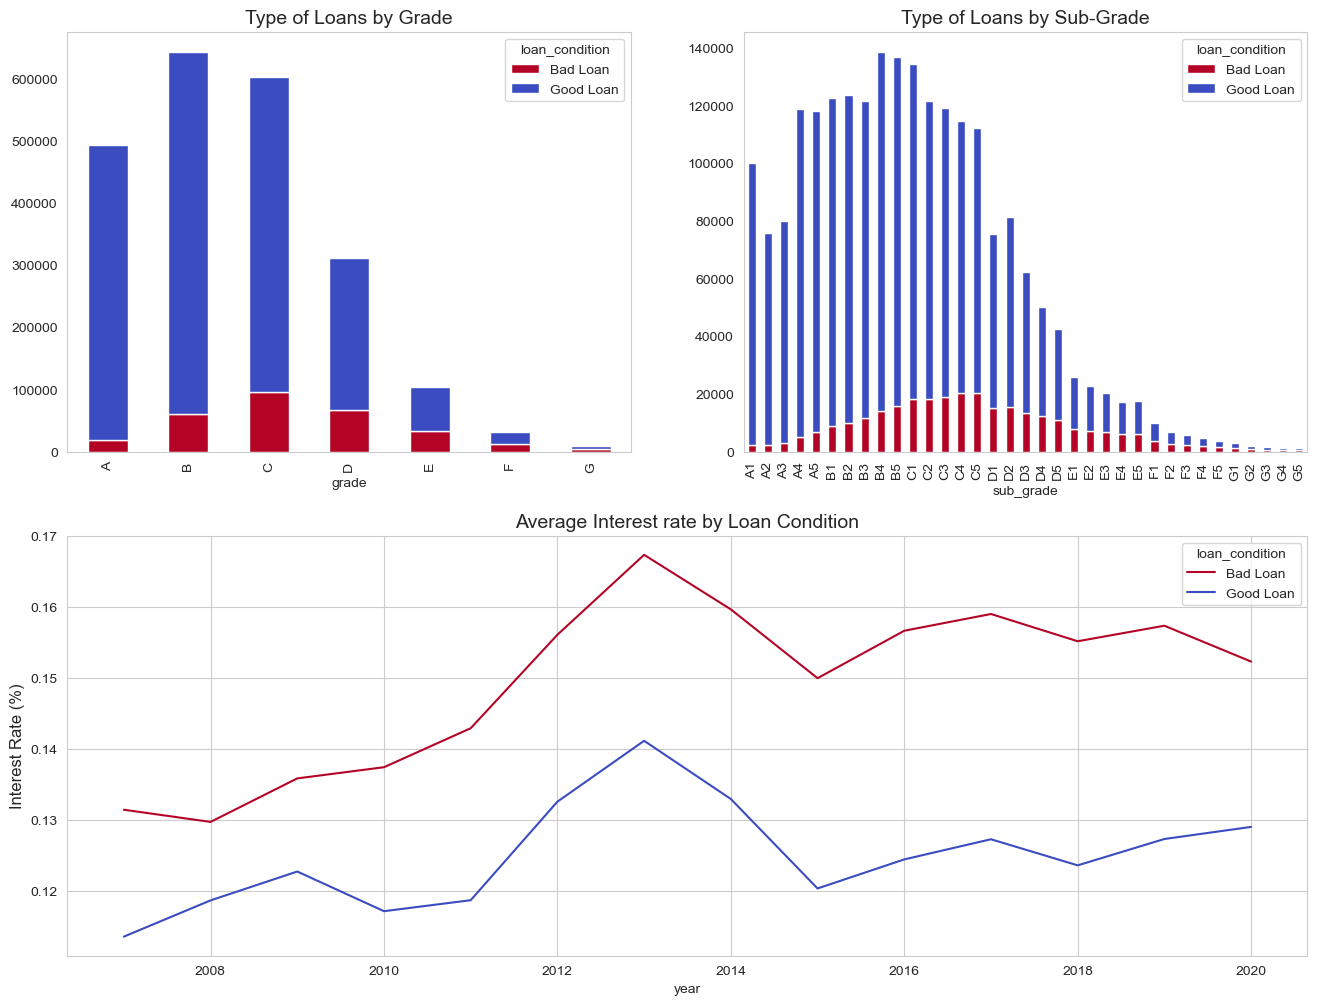

In [32]:
fig = plt.figure(figsize=(16,12))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(212)

cmap = plt.cm.coolwarm_r

loans_by_region = df.groupby(['grade', 'loan_condition']).size()
loans_by_region.unstack().plot(kind='bar', stacked=True, colormap=cmap, ax=ax1, grid=False)
ax1.set_title('Type of Loans by Grade', fontsize=14)


loans_by_grade = df.groupby(['sub_grade', 'loan_condition']).size()
loans_by_grade.unstack().plot(kind='bar', stacked=True, colormap=cmap, ax=ax2, grid=False)
ax2.set_title('Type of Loans by Sub-Grade', fontsize=14)

by_interest = df.groupby(['year', 'loan_condition']).interest_rate.mean()
by_interest.unstack().plot(ax=ax3, colormap=cmap)
ax3.set_title('Average Interest rate by Loan Condition', fontsize=14)
ax3.set_ylabel('Interest Rate (%)', fontsize=12)

The scores that has a lower grade received a larger amounts of loans (which might had contributed to a higher level of risk).
Logically, the lower the grade the higher the interest the customer had to pay back to investors.
Interstingly, customers with a grade of "C" were more likely to default on the loan

In [33]:
numeric_variables = df.select_dtypes(exclude=["object"])

In [34]:
df_correlations = df.corr()


trace = go.Heatmap(z=df_correlations.values,
                   x=df_correlations.columns,
                   y=df_correlations.columns,
                  colorscale=[[0.0, 'rgb(165,0,38)'], 
                              [0.1111111111111111, 'rgb(215,48,39)'], 
                              [0.2222222222222222, 'rgb(244,109,67)'], 
                              [0.3333333333333333, 'rgb(253,174,97)'], 
                              [0.4444444444444444, 'rgb(254,224,144)'], 
                              [0.5555555555555556, 'rgb(224,243,248)'], 
                              [0.6666666666666666, 'rgb(171,217,233)'], 
                              [0.7777777777777778, 'rgb(116,173,209)'], 
                              [0.8888888888888888, 'rgb(69,117,180)'], 
                              [1.0, 'rgb(49,54,149)']],
            colorbar = dict(
            title = 'Level of Correlation',
            titleside = 'top',
            tickmode = 'array',
            tickvals = [-0.52,0.2,0.95],
            ticktext = ['Negative Correlation','Low Correlation','Positive Correlation'],
            ticks = 'outside'
        )
                  )


layout = {"title": "Correlation Heatmap"}
data=[trace]

fig = dict(data=data, layout=layout)
iplot(fig, filename='labelled-heatmap')

ValueError: could not convert string to float: 'D'

This data looks a little but messy maybe if we focus our correlation heatmap into columns that are more worth it we might actually see a trend with the condition of the loan.

In [ ]:
title = 'Bad Loans: Loan Statuses'

labels = bad_loan # All the elements that comprise a bad loan.

len(labels)
colors = ['rgba(236, 112, 99, 1)', 'rgba(235, 152, 78, 1)', 'rgba(52, 73, 94, 1)', 'rgba(128, 139, 150, 1)',
         'rgba(255, 87, 51, 1)', 'rgba(255, 195, 0, 1)']

mode_size = [8,8,8,8,8,8]

line_size = [2,2,2,2,2,2]

x_data = [
    sorted(df['year'].unique().tolist()),
    sorted(df['year'].unique().tolist()),
    sorted(df['year'].unique().tolist()),
    sorted(df['year'].unique().tolist()), 
    sorted(df['year'].unique().tolist()),
    sorted(df['year'].unique().tolist()),
]

# type of loans
charged_off = df['loan_amount'].loc[df['loan_status'] == 'Charged Off'].values.tolist()
defaults = df['loan_amount'].loc[df['loan_status'] == 'Default'].values.tolist()
not_credit_policy = df['loan_amount'].loc[df['loan_status'] == 'Does not meet the credit policy. Status:Charged Off'].values.tolist()
grace_period = df['loan_amount'].loc[df['loan_status'] == 'In Grace Period'].values.tolist()
short_late = df['loan_amount'].loc[df['loan_status'] == 'Late (16-30 days)'].values.tolist()
long_late = df['loan_amount'].loc[df['loan_status'] == 'Late (31-120 days)'].values.tolist()

y_data = [
    charged_off,
    defaults,
    not_credit_policy,
    grace_period,
    short_late,
    long_late,
]

p_charged_off = go.Scatter(
    x = x_data[0],
    y = y_data[0],
    name = 'A. Charged Off',
    line = dict(
        color = colors[0],
        width = 3,
        dash='dash')
)

p_defaults = go.Scatter(
    x = x_data[1],
    y = y_data[1],
    name = 'A. Defaults',
    line = dict(
        color = colors[1],
        width = 3,
        dash='dash')
)

p_credit_policy = go.Scatter(
    x = x_data[2],
    y = y_data[2],
    name = 'Not Meet C.P',
    line = dict(
        color = colors[2],
        width = 3,
        dash='dash')
)

p_graced = go.Scatter(
    x = x_data[3],
    y = y_data[3],
    name = 'A. Graced Period',
    line = dict(
        color = colors[3],
        width = 3,
        dash='dash')
)

p_short_late = go.Scatter(
    x = x_data[4],
    y = y_data[4],
    name = 'Late (16-30 days)',
    line = dict(
        color = colors[4],
        width = 3,
        dash='dash')
)

p_long_late = go.Scatter(
    x = x_data[5],
    y = y_data[5],
    name = 'Late (31-120 days)',
    line = dict(
        color = colors[5],
        width = 3,
        dash='dash')
)




data=[p_charged_off, p_defaults, p_credit_policy, p_graced, p_short_late, p_long_late]

layout = dict(title = 'Types of Bad Loans <br> (Amount Borrowed Throughout the Years)',
              xaxis = dict(title = 'Year'),
              yaxis = dict(title = 'Amount Issued'),
              )

fig = dict(data=data, layout=layout)

iplot(fig, filename='line-mode')

In [ ]:
plt.figure(figsize=(18,18))

# Create a dataframe for bad loans
bad_df = df.loc[df['loan_condition'] == 'Bad Loan']

plt.subplot(211)
g = sns.boxplot(x='home_ownership', y='loan_amount', hue='loan_condition',
               data=bad_df, color='r')

g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_xlabel("Type of Home Ownership", fontsize=12)
g.set_ylabel("Loan Amount", fontsize=12)
g.set_title("Distribution of Amount Borrowed \n by Home Ownership", fontsize=16)



plt.subplot(212)
g1 = sns.boxplot(x='year', y='loan_amount', hue='home_ownership',
               data=bad_df, palette="Set3")
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
g1.set_xlabel("Type of Home Ownership", fontsize=12)
g1.set_ylabel("Loan Amount", fontsize=12)
g1.set_title("Distribution of Amount Borrowed \n through the years", fontsize=16)


plt.subplots_adjust(hspace = 0.6, top = 0.8)

plt.show()

The types of bad loans in the last year are having a tendency to decline, except for late payments (might indicate an economical recovery.)
Mortgage was the variable from the home ownership column that used the highest amount borrowed within loans that were considered to be bad.
There is a slight increase on people who have mortgages that are applying for a loan.
People who have a mortgage (depending on other factors as well within the mortgage) are more likely to ask for

In [ ]:
northe_defaults = df['loan_amount'].loc[(df['region'] == 'NorthEast') & (df['loan_status'] == 'Default')].values.tolist()
southw_defaults = df['loan_amount'].loc[(df['region'] == 'SouthWest') & (df['loan_status'] == 'Default')].values.tolist()
southe_defaults = df['loan_amount'].loc[(df['region'] == 'SouthEast') & (df['loan_status'] == 'Default')].values.tolist()
west_defaults = df['loan_amount'].loc[(df['region'] == 'West') & (df['loan_status'] == 'Default')].values.tolist()
midw_defaults = df['loan_amount'].loc[(df['region'] == 'MidWest') & (df['loan_status'] == 'Default')].values.tolist()

# Cumulative Values
y0_stck=northe_defaults
y1_stck=[y0+y1 for y0, y1 in zip(northe_defaults, southw_defaults)]
y2_stck=[y0+y1+y2 for y0, y1, y2 in zip(northe_defaults, southw_defaults, southe_defaults)]
y3_stck=[y0+y1+y2+y3 for y0, y1, y2, y3 in zip(northe_defaults, southw_defaults, southe_defaults, west_defaults)]
y4_stck=[y0+y1+y2+y3+y4 for y0, y1, y2, y3, y4 in zip(northe_defaults, southw_defaults, southe_defaults, west_defaults, midw_defaults)] 

y0_txt=['$' + str(y0) for y0 in northe_defaults]
y1_txt=['$' + str(y1) for y1 in southw_defaults]
y2_txt=['$' + str(y2) for y2 in southe_defaults]
y3_txt=['$' + str(y3) for y3 in west_defaults]
y4_txt=['$'+ str(y4) for y4 in midw_defaults]

year = sorted(df["year"].unique().tolist())

NorthEast_defaults = go.Scatter(
    x= year,
    y= y0_stck,
    text=y0_txt,
    hoverinfo='x+text',
    name='NorthEast',
    mode= 'lines',
    line=dict(width=0.5,
             color='rgb(131, 90, 241)'),
    fill='tonexty'
)
SouthWest_defaults = go.Scatter(
    x=year,
    y=y1_stck,
    text=y1_txt,
    hoverinfo='x+text',
    name='SouthWest',
    mode= 'lines',
    line=dict(width=0.5,
             color='rgb(255, 140, 0)'),
    fill='tonexty'
)

SouthEast_defaults = go.Scatter(
    x= year,
    y= y2_stck,
    text=y2_txt,
    hoverinfo='x+text',
    name='SouthEast',
    mode= 'lines',
    line=dict(width=0.5,
             color='rgb(240, 128, 128)'),
    fill='tonexty'
)

West_defaults = go.Scatter(
    x= year,
    y= y3_stck,
    text=y3_txt,
    hoverinfo='x+text',
    name='West',
    mode= 'lines',
    line=dict(width=0.5,
             color='rgb(135, 206, 235)'),
    fill='tonexty'
)

MidWest_defaults = go.Scatter(
    x= year,
    y= y4_stck,
    text=y4_txt,
    hoverinfo='x+text',
    name='MidWest',
    mode= 'lines',
    line=dict(width=0.5,
             color='rgb(240, 230, 140)'),
    fill='tonexty'
    )


data = [NorthEast_defaults, SouthWest_defaults, SouthEast_defaults, West_defaults, MidWest_defaults]

layout = dict(title = 'Amount Defaulted by Region',
              xaxis = dict(title = 'Year'),
              yaxis = dict(title = 'Amount Defaulted')
             )

fig = dict(data=data, layout=layout)
              
iplot(fig, filename='basic-area-no-bound')

In [ ]:
df['interest_rate'].describe()
# Average interest is 13.26% Anything above this will be considered of high risk let's see if this is true.
df['interest_payments'] = np.nan
lst = [df]

for col in lst:
    col.loc[col['interest_rate'] <= 13.23, 'interest_payments'] = 'Low'
    col.loc[col['interest_rate'] > 13.23, 'interest_payments'] = 'High'
    
df.head()

In [ ]:
df['term'].value_counts()

In [ ]:
from scipy.stats import norm

plt.figure(figsize=(20,10))

palette = ['#009393', '#930000']
plt.subplot(221)
ax = sns.countplot(x='interest_payments', data=df, 
                  palette=palette, hue='loan_condition')

ax.set_title('The impact of interest rate \n on the condition of the loan', fontsize=14)
ax.set_xlabel('Level of Interest Payments', fontsize=12)
ax.set_ylabel('Count')

plt.subplot(222)
ax1 = sns.countplot(x='interest_payments', data=df, 
                   palette=palette, hue='term')

ax1.set_title('The impact of maturity date \n on interest rates', fontsize=14)
ax1.set_xlabel('Level of Interest Payments', fontsize=12)
ax1.set_ylabel('Count')


plt.subplot(212)
low = df['loan_amount'].loc[df['interest_payments'] == 'Low'].values
high = df['loan_amount'].loc[df['interest_payments'] == 'High'].values


ax2= sns.distplot(low, color='#009393', label='Low Interest Payments', fit=norm, fit_kws={"color":"#483d8b"}) # Dark Blue Norm Color
ax3 = sns.distplot(high, color='#930000', label='High Interest Payments', fit=norm, fit_kws={"color":"#c71585"}) #  Red Norm Color
plt.axis([0, 36000, 0, 0.00016])
plt.legend()


plt.show()

In the last year recorded, the Midwest and SouthEast regions had the most defaults.
Loans that have a high interest rate(above 13.23%) are more likely to become a bad loan .
Loans that have a longer maturity date (60 months) are more likely to be a bad loan.

In [ ]:
avg_fully_paid = round(np.mean(df['interest_rate'].loc[df['loan_status'] == 'Fully Paid'].values), 2)
avg_current = round(np.mean(df['interest_rate'].loc[df['loan_status'] == 'Current'].values), 2) 
avg_issued = round(np.mean(df['interest_rate'].loc[df['loan_status'] == 'Issued'].values), 2)
avg_long_fully_paid = round(np.mean(df['interest_rate'].loc[df['loan_status'] == 'Does not meet the credit policy. Status:Fully Paid'].values), 2)



# Interest rate bad loans

avg_default_rates = round(np.mean(df['interest_rate'].loc[df['loan_status'] == 'Default'].values), 2)
avg_charged_off = round(np.mean(df['interest_rate'].loc[df['loan_status'] == 'Charged Off'].values), 2)
avg_long_charged_off = round(np.mean(df['interest_rate'].loc[df['loan_status'] == 'Does not meet the credit policy. Status:Charged Off'].values), 2)
avg_grace_period = round(np.mean(df['interest_rate'].loc[df['loan_status'] == 'In Grace Period'].values), 2)
avg_short_late = round(np.mean(df['interest_rate'].loc[df['loan_status'] == 'Late (16-30 days)'].values), 2)
avg_long_late = round(np.mean(df['interest_rate'].loc[df['loan_status'] == 'Late (31-120 days)'].values), 2)


# Take to a dataframe

data = [
    go.Scatterpolar(
        mode='lines+markers',
      r = [avg_fully_paid, avg_current, avg_issued, avg_long_fully_paid],
      theta = ['Fully Paid', 'Current', 'Issued', 'No C.P. Fully Paid'],
      fill = 'toself',
      name = 'Good Loans',
        line = dict(
        color = "#63AF63"
      ),
      marker = dict(
        color = "#B3FFB3",
        symbol = "square",
        size = 8
      ),
      subplot = "polar",
    ),
    go.Scatterpolar(
        mode='lines+markers',
      r = [avg_default_rates, avg_charged_off, avg_long_charged_off, avg_grace_period, avg_short_late, avg_long_late],
      theta = ['Default Rate', 'Charged Off', 'C.P. Charged Off', 'In Grace Period', 'Late (16-30 days)', 'Late (31-120 days)'],
      fill = 'toself',
      name = 'Bad Loans',
        line = dict(
        color = "#C31414"
      ),
      marker = dict(
        color = "#FF5050",
        symbol = "square",
        size = 8
      ),
      subplot = "polar2"
    )
]

layout = go.Layout(
    title="Average Interest Rates <br> Loan Status Distribution",
    showlegend = False,
     paper_bgcolor = "rgb(255, 248, 243)",
    polar = dict(
      domain = dict(
        x = [0,0.4],
        y = [0,1]
      ),
      radialaxis = dict(
        tickfont = dict(
          size = 8
        )
      ),
      angularaxis = dict(
        tickfont = dict(
          size = 8
        ),
        rotation = 90,
        direction = "counterclockwise"
      )
    ),
    polar2 = dict(
      domain = dict(
        x = [0.6,1],
        y = [0,1]
      ),
      radialaxis = dict(
        tickfont = dict(
          size = 8
        )
      ),
      angularaxis = dict(
        tickfont = dict(
          size = 8
        ),
        rotation = 90,
        direction = "clockwise"
      ),
    )
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='polar/directions')

Bad Loans: Most of the loan statuses belonging to this group pay a interest ranging from 15% - 16%.
Good Loans: Most of the loan statuses belonging to this group pay interest ranging from 12% - 13%.
There has to be a better assesment of risk since there is not that much of a difference in interest payments from Good Loans and Bad Loans.
Remember, most loan statuses are Current so there is a risk that at the end of maturity some of these loans might become bad loans.


In [ ]:
df['purpose'].value_counts()

# Education, renewable energy, wedding are the purposed that contains highest bad loans percent wise.

purpose_condition = round(pd.crosstab(df['loan_condition'], df['purpose']).apply(lambda x: x/x.sum() * 100), 2)

purpose_bad_loans = purpose_condition.values[0].tolist()
purpose_good_loans = purpose_condition.values[1].tolist()
purpose = purpose_condition.columns


bad_plot = go.Bar(
    x=purpose,
    y=purpose_bad_loans,
    name = 'Bad Loans',
    text='%',
    marker=dict(
        color='rgba(219, 64, 82, 0.7)',
        line = dict(
            color='rgba(219, 64, 82, 1.0)',
            width=2
        )
    )
)

good_plot = go.Bar(
    x=purpose,
    y=purpose_good_loans,
    name='Good Loans',
    text='%',
    marker=dict(
        color='rgba(50, 171, 96, 0.7)',
        line = dict(
            color='rgba(50, 171, 96, 1.0)',
            width=2
        )
    )
)


data = [bad_plot, good_plot]

layout = go.Layout(
    title='Condition of Loan by Purpose',
    xaxis=dict(
        title=''
    ),
    yaxis=dict(
        title='% of the Loan',
    ),
    paper_bgcolor='#FFF8DC',
    plot_bgcolor='#FFF8DC',
    showlegend=True
)

fig = dict(data=data, layout=layout)
iplot(fig, filename='condition_purposes')

In [ ]:
loan_count = df.groupby(['income_category', 'purpose'])['loan_condition'].apply(lambda x: x.value_counts())
d={"loan_c": loan_count}
loan_c_df = pd.DataFrame(data=d).reset_index()
loan_c_df = loan_c_df.rename(columns={"level_2": "loan_condition"})


# Good loans & Bad Loans
good_loans = loan_c_df.loc[loan_c_df['loan_condition'] == "Good Loan"].sort_values(by="income_category", ascending=True)
bad_loans = loan_c_df.loc[loan_c_df['loan_condition'] == "Bad Loan"].sort_values(by="income_category", ascending=True)
sort_group_income_purpose['good_loans_count'] = good_loans['loan_c'].values
sort_group_income_purpose['bad_loans_count'] = bad_loans['loan_c'].values
sort_group_income_purpose['total_loans_issued'] = (good_loans['loan_c'].values + bad_loans['loan_c'].values)
sort_group_income_purpose['bad/good ratio (%)'] = np.around(bad_loans['loan_c'].values / (bad_loans['loan_c'].values + good_loans['loan_c'].values), 4) * 100
final_df = sort_group_income_purpose.sort_values(by='income_category', ascending=True)
final_df.style.background_gradient('coolwarm')

In [ ]:
final_df = final_df.sort_values(by="purpose", ascending=False)

In [ ]:
purpose_labels = df['purpose'].unique()

# Average Interest Rate Dot Plots # 1st Subplot
high_income = final_df['interest_rate'].loc[final_df['income_category'] == 'High'].values.tolist()
medium_income = final_df['interest_rate'].loc[final_df['income_category'] == 'Medium'].values.tolist()
low_income = final_df['interest_rate'].loc[final_df['income_category'] == 'Low'].values.tolist()

high_lst = ['%.2f' % val for val in high_income]
med_lst = ['%.2f' % val for val in medium_income]
low_lst = ['%.2f' % val for val in low_income]



trace1 = {"x": high_lst,
          "y": purpose_labels,
          "marker": {"color": "#0040FF", "size": 16},
          "mode": "markers",
          "name": "High Income",
          "type": "scatter"
}

trace2 = {"x": med_lst,
          "y": purpose_labels,
          "marker": {"color": "#FE9A2E", "size": 16},
          "mode": "markers",
          "name": "Medium Income",
          "type": "scatter",
}

trace3 = {"x": low_lst,
          "y": purpose_labels,
          "marker": {"color": "#FE2E2E", "size": 16},
          "mode": "markers",
          "name": "Low Income",
          "type": "scatter",
}




data = [trace1, trace2, trace3]
layout = {"title": "Average Purpose Interest Rate <br> <i> by Income Category </i> ",
          "xaxis": {"title": "Average Interest Rate", },
          "yaxis": {"title": ""}}

fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [ ]:
purpose_labels = final_df['purpose'].unique()

# Amount of Good and Bad Loans per Purpose (fill by income category)
# Good Loans
good_high_cnt = final_df['good_loans_count'].loc[final_df['income_category'] == "High"].values.tolist()
good_med_cnt = final_df['good_loans_count'].loc[final_df['income_category'] == "Medium"].values.tolist()
good_low_cnt = final_df['good_loans_count'].loc[final_df['income_category'] == "Low"].values.tolist()

# Bad Loans
bad_high_cnt = final_df['bad_loans_count'].loc[final_df['income_category'] == "High"].values.tolist()
bad_med_cnt = final_df['bad_loans_count'].loc[final_df['income_category'] == "Medium"].values.tolist()
bad_low_cnt = final_df['bad_loans_count'].loc[final_df['income_category'] == "Low"].values.tolist()


# Good Loans
trace0 = go.Bar(
    y=purpose_labels,
    x=good_high_cnt,
    legendgroup='a',
    name='High Income',
    orientation='h', 
    marker=dict(
        color='#0040FF'
    )
)
trace1 = go.Bar(
    x=good_med_cnt,
    y=purpose_labels,
    legendgroup='a',
    name='Medium Income',
    orientation='h',
    marker=dict(
        color='#FE9A2E',
    )
)

trace2 = go.Bar(
    x=good_low_cnt,
    y=purpose_labels,
    legendgroup='a',
    name='Low Income',
    orientation='h',
    marker=dict(
        color='#FE2E2E',
    )
)

# Bad Loans issued by Income Category
trace3 = go.Bar(
    y=purpose_labels,
    x=bad_high_cnt,
    legendgroup='b',
    showlegend=False,
    name='High Income',
    orientation='h', 
    marker=dict(
        color='#0040FF'
    )
)
trace4 = go.Bar(
    x=bad_med_cnt,
    y=purpose_labels,
    legendgroup='b',
    showlegend=False,
    name='Medium Income',
    orientation='h',
    marker=dict(
        color='#FE9A2E',
    )
)

trace5 = go.Bar(
    x=bad_low_cnt,
    y=purpose_labels,
    legendgroup='b',
    showlegend=False,
    name='Low Income',
    orientation='h',
    marker=dict(
        color='#FE2E2E',
    )
)



fig = tools.make_subplots(rows=2, cols=1, print_grid=False,
                         subplot_titles=("Amount of <br> <i>Good Loans Issued</i>",
                                        "Amount of <br> <i>Bad Loans Issued</i>")
                         )

# First Subplot
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 1)

# Second Subplot
fig.append_trace(trace3, 2, 1)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 1)

fig['layout'].update(height=800, width=800, title='Issuance of Loans', showlegend=True, xaxis=dict(title="Number of Loans Issued"))
iplot(fig, filename='angled-text-bar')

In [ ]:
high_ratio = final_df.loc[final_df['income_category'] == 'High']
medium_ratio = final_df.loc[final_df['income_category'] == 'Medium']
low_ratio = final_df.loc[final_df['income_category'] == 'Low']

data = [
    go.Scatterpolar(
        mode='lines+markers',
      r = high_ratio['bad/good ratio (%)'].values.tolist(),
      theta = high_ratio['purpose'].unique(),
      fill = 'toself',
      name = 'High Income',
        line = dict(
        color = "#63AF63"
      ),
      marker = dict(
        color = "#B3FFB3",
        symbol = "square",
        size = 8
      ),
      subplot = "polar",
    ),
    go.Scatterpolar(
        mode='lines+markers',
      r = medium_ratio['bad/good ratio (%)'].values.tolist(),
      theta = medium_ratio['purpose'].unique(),
      fill = 'toself',
      name = 'Medium Income',
        line = dict(
        color = "#C31414"
      ),
      marker = dict(
        color = "#FF5050",
        symbol = "square",
        size = 8
      ),
      subplot = "polar2"
    ),
    go.Scatterpolar(
        mode='lines+markers',
      r = low_ratio['bad/good ratio (%)'].values.tolist(),
      theta = low_ratio['purpose'].unique(),
      fill = 'toself',
      name = 'Low Income',
        line = dict(
        color = "#C9FFC7"
      ),
      marker = dict(
        color = "#8CB28B",
        symbol = "square",
        size = 8
      ),
      subplot = "polar3"
    ),
]

layout = go.Layout(
    title="Bad/Good Ratio <br> (By Purpose)",
    showlegend = False,
     paper_bgcolor = "rgb(255, 206, 153)",
    polar = dict(
      domain = dict(
        x = [0,0.3],
        y = [0,1]
      ),
      radialaxis = dict(
        tickfont = dict(
          size = 6
        )
      ),
      angularaxis = dict(
        tickfont = dict(
          size = 6
        ),
        rotation = 90,
        direction = "counterclockwise"
      )
    ),
    polar2 = dict(
      domain = dict(
        x = [0.35,0.65],
        y = [0,1]
      ),
      radialaxis = dict(
        tickfont = dict(
          size = 6
        )
      ),
      angularaxis = dict(
        tickfont = dict(
          size = 6
        ),
        rotation = 85,
        direction = "clockwise"
      ),
    ),
    polar3 = dict(
      domain = dict(
        x = [0.7, 1],
        y = [0,1]
      ),
      radialaxis = dict(
        tickfont = dict(
          size = 6
        )
      ),
      angularaxis = dict(
        tickfont = dict(
          size = 6
        ),
        rotation = 90,
        direction = "clockwise"
      ),
    ))

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename = "radar/multiple")

Bad Loans Count: People that apply for educational and small business purposed tend to have a higher risk of being a bad loan. (% wise)
Most frequent Purpose: The reason that clients applied the most for a loan was to consolidate debt.
Less frequent purpose: Clients applied less for educational purposes for all three income categories.
Interest Rates: In all reasons for application except (medical, small business and credi card), the low income category has a higher interest rate. Something that could possibly explain this is the amount of capital that is needed from other income categories that might explain why the low income categories interest rate for these puposes are lower.
Bad/Good Ratio: Except for educational purposes (we see a spike in high income this is due to the reasons that only two loans were issued and one was a bad loan which caused this ratio to spike to 50%.), but we can see that in all other purposed the bad good ratio is lower the higher your income category.